# Text classification of Transactions
### Sections:
* [1. Load datasets](#section1)
* [2. Data analysis](#section2)
* [3. Training pipeline](#section3)
* [4. Model analysis](#section4)
* [5. Postprocessing](#section5)

Some useful imports:

In [142]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

Fix random seed:

In [143]:
np.random.seed(1234)

def save(model, path):
    pickle.dump(model, open( path, 'wb'))
    
def load(path):
    return pickle.load(open(path,'rb'))

# 1. Load the data <a id="section1"/>

In [144]:
data = pd.read_csv('500k.csv',sep='\t',header=None, names=['INN', 'KPP','Type','Description'])
data.drop(['INN', 'KPP'], axis=1, inplace=True)
data = pd.DataFrame({'Type': np.array(data['Type'], dtype='int'), 'Description': np.array(data['Description'])})
data = data[['Type', 'Description']]
data_initial = data.copy()

In [145]:
print('Data size: ', data.shape)
data.head()

Data size:  (500000, 2)


,Type,Description
0,4022,Предоплата за поверку СИ по счетам N 140808 от...
1,4022,Оплата услуг по договору N40077 от 9 февраля 2...
2,4022,"Aвансовый платеж за услугибульдозеров SD32, CA..."
3,3001,Оплата за Проектные работыи предпроектные прор...
4,4018,предоплата за рекламу в газете и на сайте Ком...


In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
Type           500000 non-null int32
Description    498135 non-null object
dtypes: int32(1), object(1)
memory usage: 5.7+ MB


Drop NaN values:

In [147]:
data.dropna(inplace=True)
print('Data size: ', data.shape)

Data size:  (498135, 2)


And duplicates:

In [148]:
#data.drop_duplicates(subset=['Type','Description'], inplace=True)
#print('Data size without duplicates: ', data.shape)

In [149]:
data.drop_duplicates(subset=['Description'], inplace=True)
print('Data size without duplicates: ', data.shape)

Data size without duplicates:  (423283, 2)


In our data we have a lot of lines containing only **"№REF..."** part:

In [150]:
data.loc[30740].Description

'№REF132<<ИМЯ>ИНН=КПП='

Let's drop them as well:

In [151]:
bList_to_drop = data.Description.str.contains('^№REF*')
data = data.drop(data[bList_to_drop].index, axis=0, inplace=False)

In [152]:
data.shape

(420109, 2)

In [153]:
data.Description = data.Description.str.replace(r'(?i)ref', ' ref ')
data.Description = data.Description.str.replace(r'(?i)кпп', ' кпп ')
data.Description = data.Description.str.replace(r'(?i)инн', ' инн ')

In [154]:
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')

# 2. Data analysis <a id="section2"/>

In [155]:
print('The number of classes: ', len(np.unique(y)))
unique, counts = np.unique(y, return_counts=True)
data_dict = dict(zip(unique, counts))

The number of classes:  132


In [156]:
def idx_by_count(count):
    return np.where(np.array(list(data_dict.values())) == count)[0]

def key_by_count(count):
    return np.array(list(data_dict.items()))[:,0][idx_by_count(count)]

Plot now a diagram of interclass distribution:

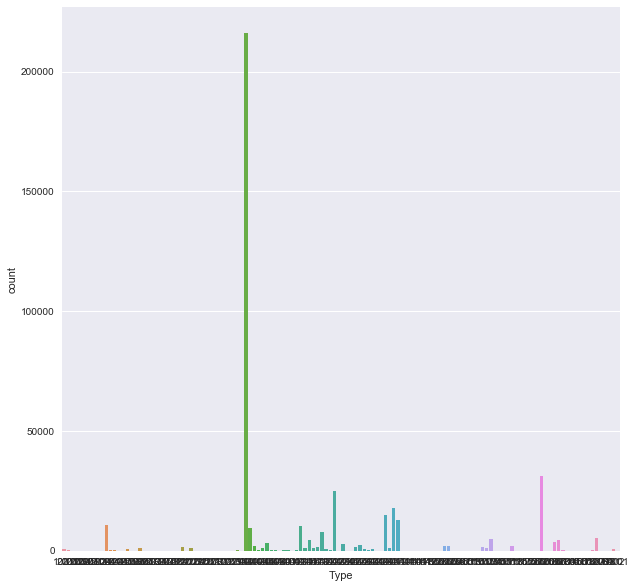

In [157]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data)

We see that we have 25% of our data belonging to one class, which means that our data is strongly unbalanced. Find this class:

In [158]:
print("Most populated class is: ", key_by_count(counts.max()))

Most populated class is:  [3001]


Delete 75% of this class instances:

In [159]:
data_cleared= data.drop(data[data.Type==3001].index[::2], inplace=False)
data_cleared = data_cleared.drop(data_cleared[data_cleared.Type==3001].index[::2], inplace=False)

In [160]:
data_3001_1 = data.drop(data[data.Type == 3001].index[1::2], inplace=False)
data_3001_2 = data_3001_1.drop(data_3001_1[data_3001_1.Type == 3001].index[1::2], inplace=False)
data_3001_1 = data_3001_1[data_3001_1.Type == 3001].copy()
data_3001_2 = data_3001_2[data_3001_2.Type == 3001].copy()
data_3001 = pd.concat([data_3001_1, data_3001_2], axis=0, join='inner')

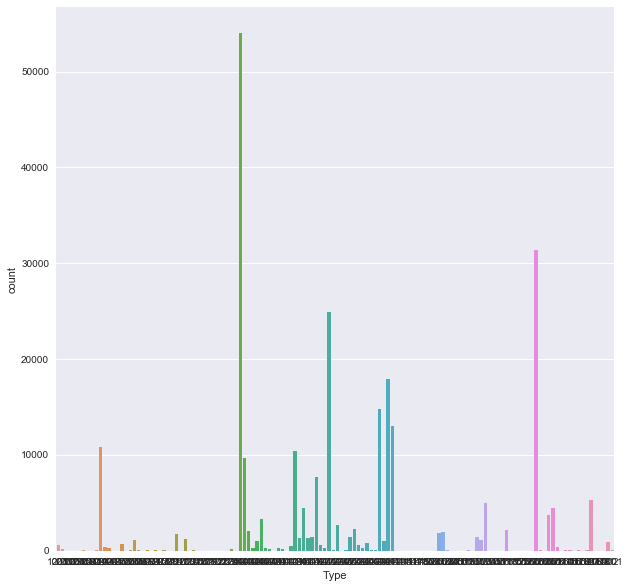

In [161]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

And we have several classes that are very rare:

In [162]:
print("Classes with only 1 sample: ", key_by_count(1))

Classes with only 1 sample:  [2011 2047 2074 2084 2120 2129 4105 4117 5010 5125 6218]


In [163]:
print("Classes with only 2 sample: ", key_by_count(2))

Classes with only 2 sample:  [2002 2005 2110 2127 4110 5105]


Delete the entries in data with the total number of a class less than 10:

In [164]:
def delete_minor_classes(data, min_count = 10):
    data_copy = data.copy()
    for i in range(1, min_count + 1):
        classes = key_by_count(i)
        for class_name in classes:
            data_copy.drop(data_copy[data_copy.Type==class_name].index, inplace=True)
    return data_copy

In [165]:
data_cleared = delete_minor_classes(data_cleared, 10)

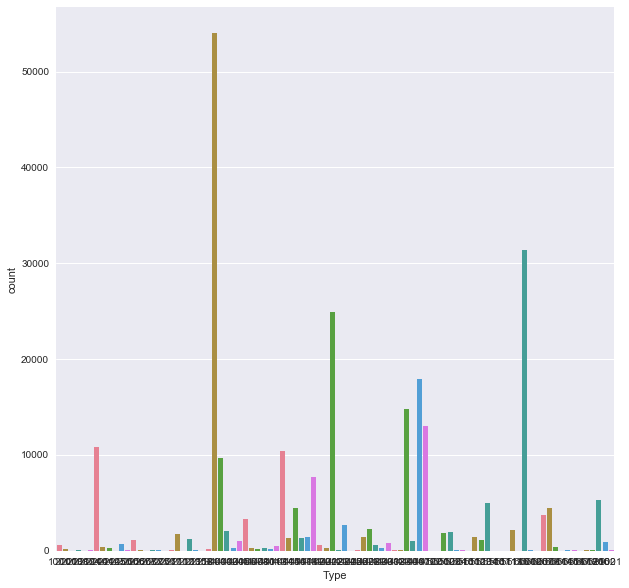

In [176]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared, palette=sns.color_palette("husl"))
sns.plt.savefig('fig1.png')

# 3. Preprocessing and training pipeline <a id="section3"/>

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from utils import stemming

## 3.1 Classification using cleared data <a id="section3.1"/>

 As we have seen, our data is highly unbalanced, thus we can try to use cleared data, where the most populated class is reduced.

Split the data into train and test sets:

In [27]:
test_size = 0.2
X = np.array(data_cleared['Description'])
y = np.array(data_cleared['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [28]:
parameters = {'vect__ngram_range': [(1, 2),(1,1)],
              'vect__min_df': [3, 5, 10],
              'vect__max_df': [0.6, 0.7,0.8],
              'tfidf__use_idf': [True],
              'clf__alpha': [1e-7],
              'clf__loss': ['log','modified_huber'],
              'clf__max_iter': [50],
              'clf__penalty': ['l1']
}

text_clf = Pipeline([('vect', CountVectorizer(analyzer=stemming)),
                     ('tfidf', TfidfTransformer(norm='l1')),
                     ('clf', SGDClassifier(loss='log',tol=1e-3,
                                           random_state=1234,
                                           n_jobs=-1))
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=5)

Train a classifier:

In [29]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 89.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 478.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 807.2min finished


In [30]:
gs_clf.best_params_

{'clf__alpha': 1e-07,
 'clf__loss': 'log',
 'clf__max_iter': 50,
 'clf__penalty': 'l1',
 'tfidf__use_idf': True,
 'vect__max_df': 0.6,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 2)}

on 100% of data with regex without BAD DUPLICATES

In [31]:
gs_clf.best_score_

0.94073194377120695

on 100% of data without bad entries with regex without BAD DUPLICATES

In [33]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, y_pred))

Accuracy on the train:  0.969185651963
Accuracy on the test:  0.946215293935


In [34]:
save(best_clf,"last_clf.pkl")

## 3.2 Classification using `modified_huber loss` <a id="section3.2"/>

In [142]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=stemming, min_df = 30, max_df = 0.7, ngram_range=(1,3))),
                     ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
                     ('clf', SGDClassifier(loss='modified_huber', alpha=1e-6, max_iter=50,
                                           random_state=1234, penalty='l1',
                                           n_jobs=-1))
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemming at 0x0000011CB28E88C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.7,
        max_features=None, min_df=30, ngram_range=(1, 3),
        prepr...power_t=0.5,
       random_state=1234, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [143]:
y_pred = pipe.predict(X_test)

In [144]:
print('Accuracy on the train: ', accuracy_score(y_train, pipe.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, y_pred))

Accuracy on the train:  0.943926387359
Accuracy on the test:  0.921620389714


In [32]:
save(pipe, "pipe_0.912.pkl" )

## 3.3 Multi-layer Perceptron <a id="section3.3"/>

In [48]:
from sklearn.neural_network import MLPClassifier

In [53]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=stemming, min_df = 20, max_df = 0.76, ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
                     ('clf', MLPClassifier(solver='adam', alpha=1e-7, hidden_layer_sizes=(400, 200),
                    activation='relu', random_state=1234, early_stopping=True))
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemming at 0x0000022F81116840>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.76,
        max_features=None, min_df=20, ngram_range=(1, 2),
        prep...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [54]:
print('Accuracy on the train: ', accuracy_score(y_train, pipe.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, pipe.predict(X_test)))

Accuracy on the train:  0.872755940879
Accuracy on the test:  0.864203769206


# 4. Model Analysis <a id="section4"/>

In [37]:
clf = best_clf
#clf = pipe

Some useful function:

In [38]:
def class_by_idx(y, index):
    unique, counts = np.unique(y, return_counts=True)
    data_dict = dict(zip(unique, counts))
    return np.array(list(data_dict.keys()))[index]

def find_most_probable_class(y, probabilities, n_classes=2):
    probabilities = probabilities[0]
    sorted_prob = np.sort(probabilities)
    idx_sorted_prob = probabilities.argsort()
    return class_by_idx(y, idx_sorted_prob[-n_classes:][::-1]), sorted_prob[-n_classes:][::-1]

def lazy_print(idx):
    print('%r => %s, true: %s' % (X_test[idx], best_clf.predict([X_test[idx]]),y_test[idx]))
    
def pretty_print_of_confusion_matrix(C, classes):
    n = C.shape[0]
    flag = 0
    for row in range(n):
        for column in range(n):
            #if row==column:
            if flag == 0:
                print(">> Class %d true: \t\t [%d]" % (classes[row], C[row, row]) )
            else:
                if C[row, column] + C[column, row] != 0 and column != row:
                    print(">> Classes (%d vs. %d): \t [%d] and [%d]" % 
                          (classes[row], classes[column], C[row, column], C[column,row]))
            flag += 1
            if flag == n:
                flag = 0

# def max_c(C, classes):
#     cij_max = 0
#     ci_max = 0
#     for i in range(C.shape[0]):
#         ci_max = 0
#         for j in range(C.shape[0]):
#             if C[i,j] + C[j,i] > cij_max and i != j:
#                 cij_max = C[i,j] + C[j,i]
#                 idx = (i,j)
#     return classes[idx[0]], classes[idx[1]], cij_max

First of all, loot at the confusion matrix:

In [39]:
classes = clf.classes_
C = confusion_matrix(y_test, y_pred, labels=classes)

In [40]:
pretty_print_of_confusion_matrix(C, classes)

>> Class 1001 true: 		 [118]
>> Classes (1001 vs. 2008): 	 [0] and [4]
>> Classes (1001 vs. 2041): 	 [0] and [2]
>> Classes (1001 vs. 3001): 	 [4] and [0]
>> Classes (1001 vs. 4001): 	 [3] and [0]
>> Classes (1001 vs. 4016): 	 [1] and [0]
>> Classes (1001 vs. 4022): 	 [2] and [0]
>> Class 2001 true: 		 [28]
>> Classes (2001 vs. 2040): 	 [0] and [2]
>> Classes (2001 vs. 4001): 	 [4] and [0]
>> Classes (2001 vs. 4006): 	 [1] and [0]
>> Classes (2001 vs. 4040): 	 [2] and [0]
>> Class 2003 true: 		 [1]
>> Classes (2003 vs. 4002): 	 [1] and [0]
>> Classes (2003 vs. 4022): 	 [1] and [0]
>> Classes (2003 vs. 4070): 	 [1] and [0]
>> Class 2008 true: 		 [11]
>> Classes (2008 vs. 2024): 	 [0] and [1]
>> Classes (2008 vs. 2041): 	 [2] and [0]
>> Classes (2008 vs. 2050): 	 [0] and [1]
>> Classes (2008 vs. 3001): 	 [2] and [0]
>> Classes (2008 vs. 4001): 	 [1] and [0]
>> Classes (2008 vs. 4016): 	 [1] and [0]
>> Classes (2008 vs. 4022): 	 [1] and [0]
>> Class 2010 true: 		 [2]
>> Classes (2010 vs. 

In [41]:
C_ = np.array(C, dtype='int')
for i in range(C_.shape[0]):
    C_[i,i] = 150
    #C_[i,i] = ((1 - C[i,i]/(y_test == classes[i]).sum())*100)

In [42]:
######################

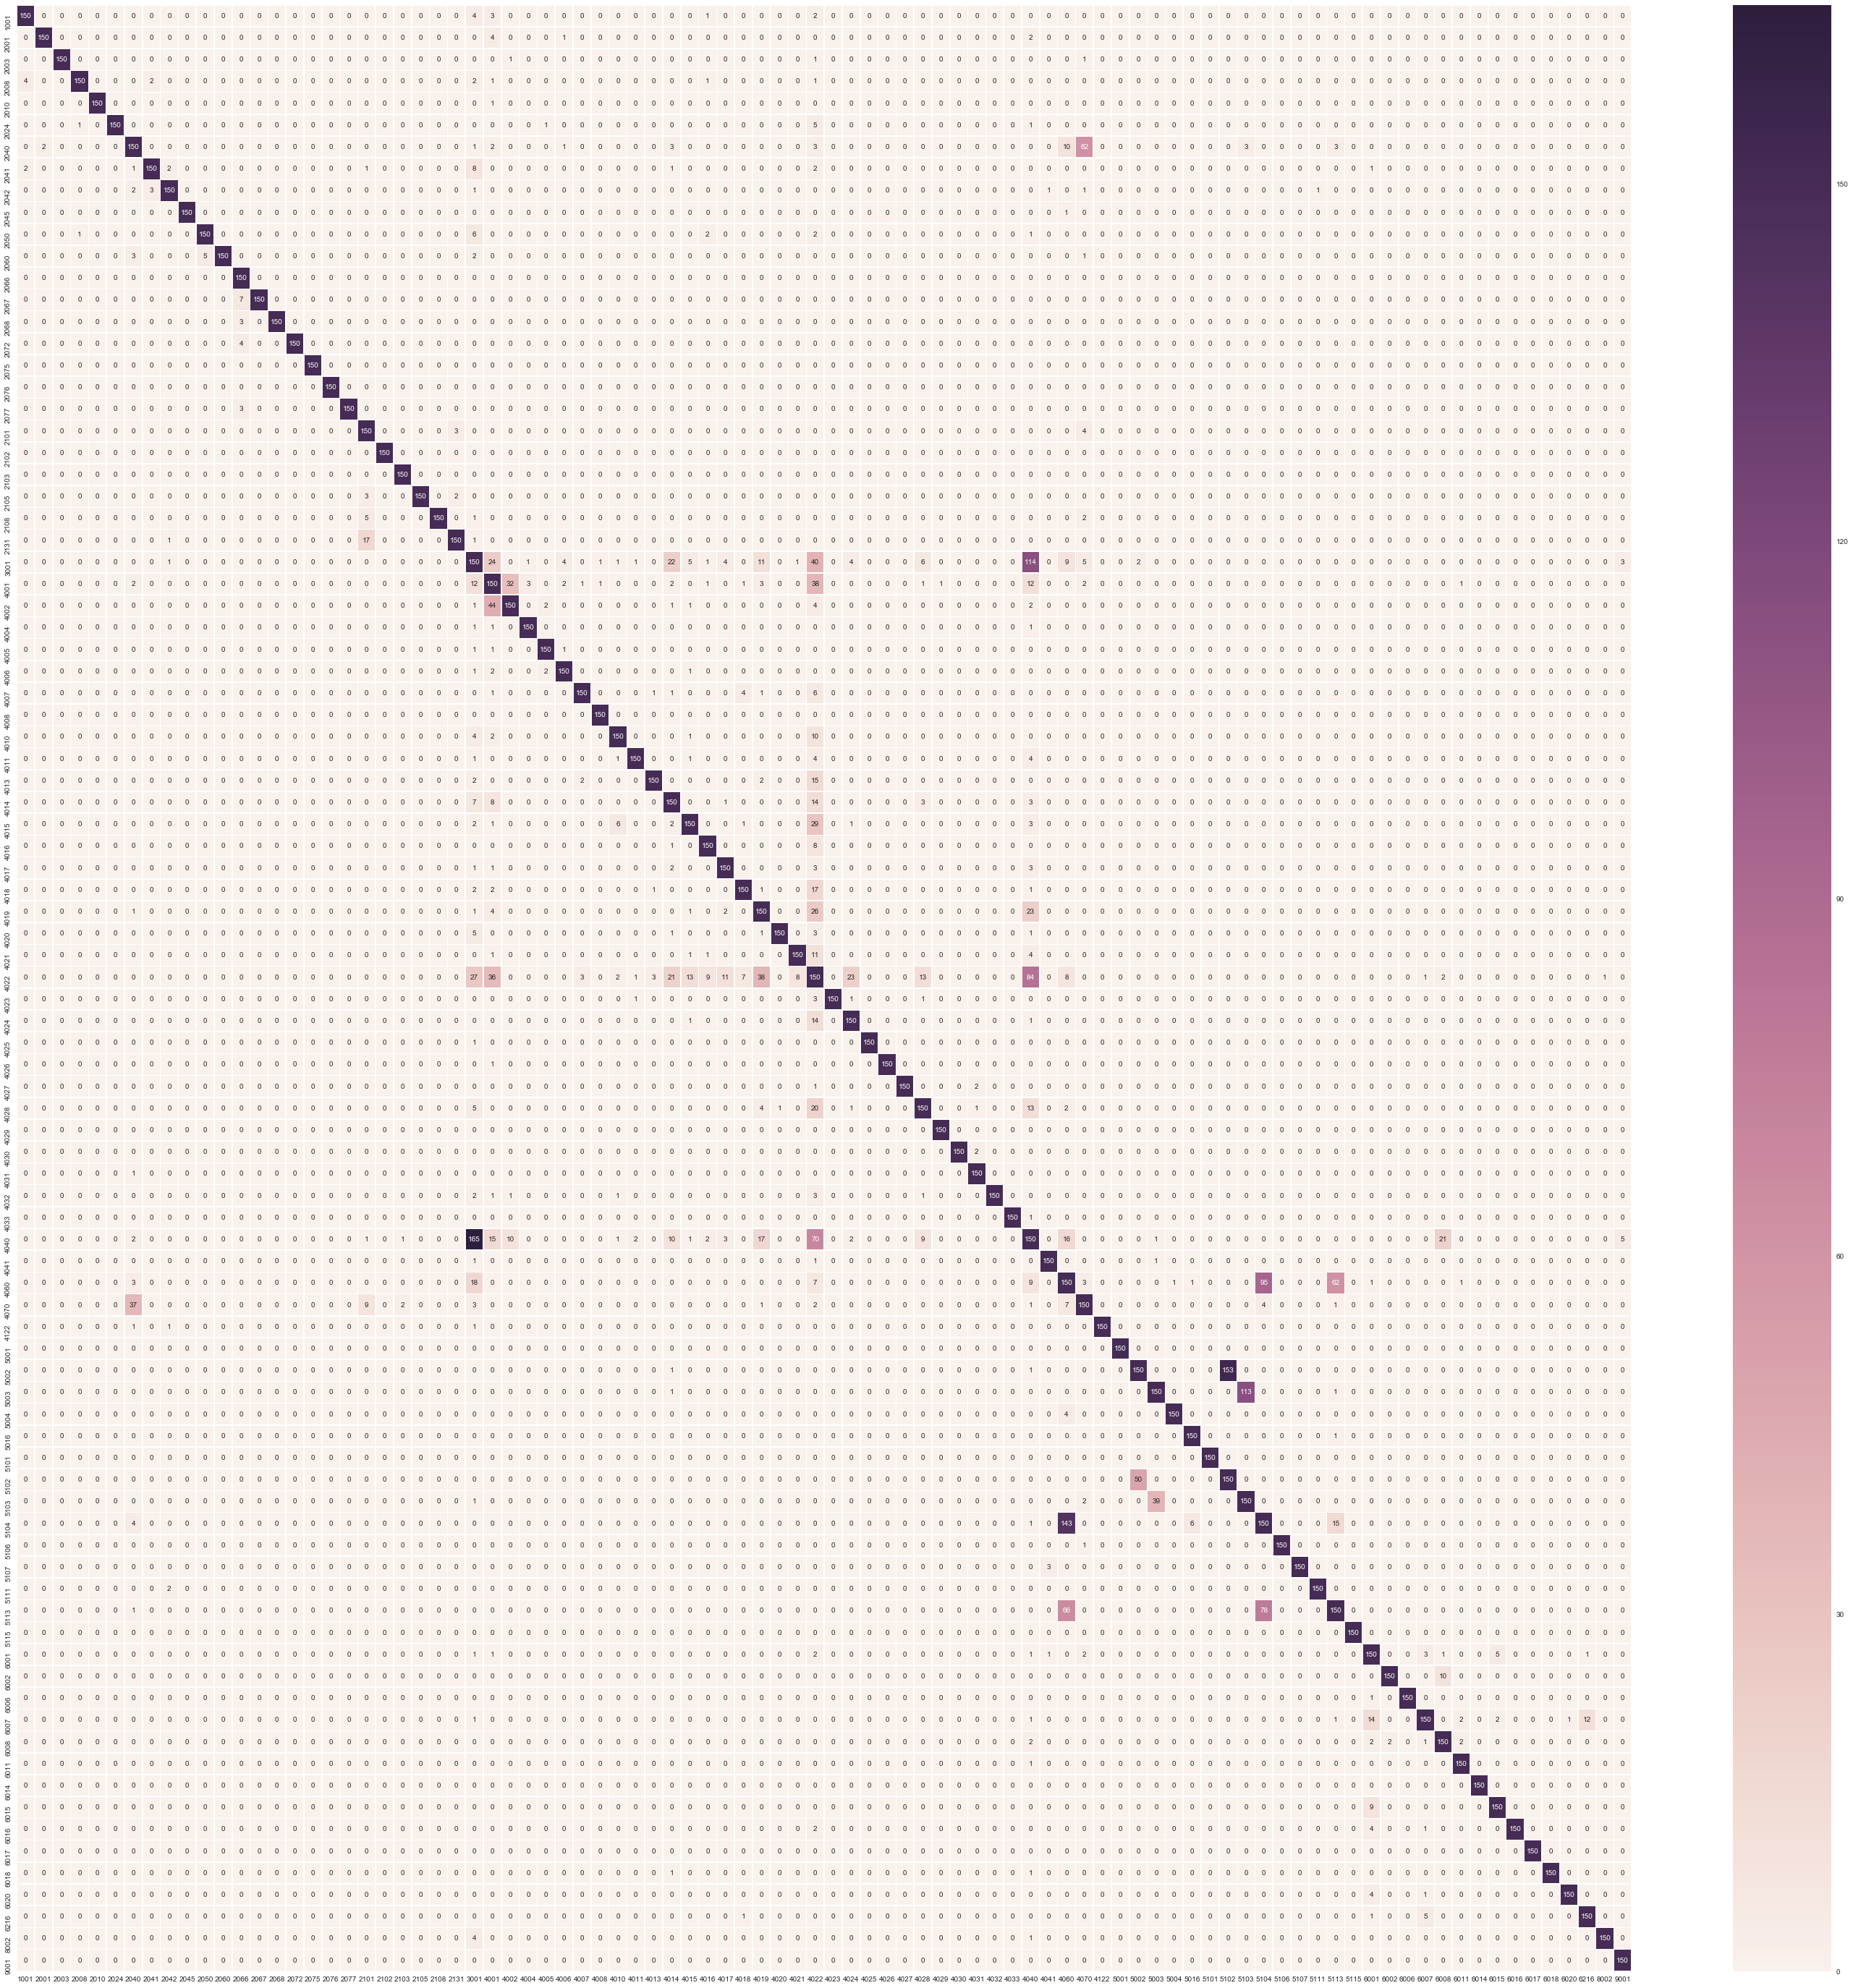

In [43]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(C_, annot=True, fmt="d", linewidths=.5, ax=ax, xticklabels=classes, yticklabels=classes)
sns.plt.savefig('heatmap_last_clf.png')

## <font color="Blue">Consider several difficult cases:</font>

After exploring the heatmap, we see that there are two different cases: a peak error for 2 classes and a long tail of error for a certain class.

## 4.1 Peak errors <a id="section4.1"/>

### 4.1.1 Example #1

Lets look at errors that belongs to classification of **4070** and **2040** classes. Take a look at them:

In [55]:
data[data.Type == 4070].tail(2)

,Type,Description
496571,4070,Частичное погашение займа по договору беспроце...
497622,4070,Частичное погашение займа по договору беспроце...


In [56]:
data[data.Type == 2040].iloc[25:27]

,Type,Description
38064,2040,Возврат займа по договору 98633 от 25.05.2012г...
38155,2040,{VO01030} Зачисление иностранной валюты по зая...


In [59]:
errors_type_1 = X_test[(y_test == 4070) & (y_pred == 2040)].copy()
errors_type_1[:20]

array([ '[КП] ПЛАТЕЖ ПО ДОГОВОРУ ЗАЙМА, НДС НЕ ОБЛАГАЕТСЯ№ ref 255<<ИМЯ> инн =4823006703 кпп =997550001',
       '[КП] платеж по договору займа, НДС не облагается№ ref 162<<ИМЯ> инн =4823006703 кпп =997550001',
       'Покупка валютных средств, поручение на покупку валютных средств по ПП 1 от 24/11/2015№ ref 1<<ИМЯ> инн =2205001753 кпп =',
       '[КП] платеж по договору займа, НДС не облагается НДС не облагается№ ref 34<<ИМЯ>ПАО  НЛМК инн =4823006703 кпп =997550001',
       'КП] платеж по договору займа НДС не облагается<<ИМЯ>ОАО  АЛТАЙ-КОКС инн =2205001753 кпп =220250001',
       'Оплата за покупку векселейпо договору 6-26/2013 купли-продажи векселей ГПБ (ОАО) от 04,07,2013. НДС не облагается<<ИМЯ>Общество с ограниченной ответственностью  ВИЗ-Сталь инн =7744001497 кпп =',
       '1708945.608768.600966№ ref AMphD0221134<<ИМЯ> инн = кпп =',
       'Конверсионная сделка N 269349. Обмен валюты. по курсу.07№ ref 8307980<<ИМЯ> инн = кпп =',
       '[КП] ПЛАТЕЖ ПО ДОГОВОРУ ЗАЙМА, НДС НЕ ОБЛ

In [60]:
probs = clf.predict_proba(errors_type_1)

In [61]:
find_most_probable_class(y_train, probs)

(array([2040, 4070]), array([ 0.50050831,  0.49240204]))

### 4.1.2 Example #2

Take another high error from the heatmap that belongs to classification of **5104** and **4060** classes. Take a look at them:

In [179]:
X_test[(y_test == 5104) & (y_pred == 4060)]

array([ 'Конверсионная сделка N 113111. Продажа Доллар Сша. покурсу 68.53. Курс: 68,53№ ref 6958674<<ИМЯ>ВИЗ-СТАЛЬ инн =6658084667 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000926 от 13.12.2016. Курс 61.27500№ ref 161637<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000793 от 28.10.2016. Курс 62.80500№ ref 60117<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0001037 от 17.01.2017. Курс 59.27000№ ref 125554<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       'Продажа валюты по курсу Банка. Курс: 65.2800№ ref <<ИМЯ> инн =6658084667 кпп =997550001',
       '{VO01010} Операция по продаже валюты по заявлению №0000521 от 08.07.2016. Курс 64.13500№ ref 84427<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000229 от 23.12.2016. Курс 60.78000№ 

In [177]:
X_test[(y_test == 4060) & (y_pred == 5104)]

array([ 'Конверсионная сделка N 122607. Продажа Доллар Сша. покурсу 70.59. Курс: 70,59№ ref 7170856<<ИМЯ>ВИЗ-СТАЛЬ инн =6658084667 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000260 от 12.05.2016. Курс 64.96100№ ref 147915<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000138 от 26.04.2016. Курс 66.49500№ ref 19419<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000568 от 25.07.2016. Курс 64.88750№ ref 335008<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0001078 от 26.01.2017. Курс 59.14880№ ref 103658<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000963 от 22.12.2016. Курс 60.82250№ ref 111415<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция п

In [64]:
data_initial[data_initial.Description == 'Покупка/продажа валюты по заявке № 807(807).№REF<<ИМЯ>ИНН=4823006703']

,Type,Description
48320,4060,Покупка/продажа валюты по заявке № 807(807).№R...
481141,5104,Покупка/продажа валюты по заявке № 807(807).№R...


# <font color="red">???</font>

In [67]:
entry = 'Покупка/продажа валюты по заявке'
find_most_probable_class(y_train, best_clf.predict_proba([entry]))

(array([4060, 5016]), array([ 0.97437371,  0.01223187]))

In [66]:
entry = 'Покупка/продажа валюты по заявке № 807(807).№REF<<ИМЯ>ИНН=4823006703'
find_most_probable_class(y_train, best_clf.predict_proba([entry]))

(array([4060, 5104]), array([ 0.99034137,  0.00615294]))

***

Take another high error from the heatmap that belongs to classification of **5113** and **4060** classes. Take a look at them:

In [71]:
X_test[(y_test == 5113) & (y_pred == 4060)][5:10]

array([ '{VO01010} Операция по продаже валюты по заявлению №0000732 от 17.10.2016. Курс 69.38250№ ref 304349<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000148 от 12.05.2016. Курс 74.18700№ ref 16979<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000179 от 15.07.2016. Курс 70.35000№ ref 23536<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000853 от 15.11.2016. Курс 70.65000№ ref 217675<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       'Покупка/продажа валюты по заявке № 348(348).№ ref 348<<ИМЯ>НЛМК ОАО инн =4823006703'], dtype=object)

In [73]:
entry = 'Операция по продаже валюты по заявлению №0000732 от 17.10.2016. Курс 69.38250№ ref 304349<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп ='
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([5104, 5113, 2040]),
 array([  5.57869637e-01,   4.39541907e-01,   4.01541589e-04]))

In [74]:
entry = 'Покупка/продажа валюты по заявке '
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([4060, 5016, 4033]), array([ 0.97437371,  0.01223187,  0.00511216]))

### 4.1.5 Example #3

We see that our classifier confuses **5103** and **5003** classes, and in our data we have several entries, which belong to that classes:

In [75]:
X_test[(y_test == 5103) & (y_pred == 5003)][:10]

array([ 'Зачисление инвалюты по операции обязательной продажи валюты согласно клиентскогоРаспоряжения 35 от 13/10/2016 на 1900000 EUR по курсу0 АО  НЛМК-Урал№ ref 415135<<ИМЯ> инн =6646009256 кпп =',
       'Перевод суммы поступившей экспортной валютной выручки<<ИМЯ>OJSC Novolipetsk Steel инн =4823006703 кпп =',
       '302 ZACV KA N 030270 OT 03/02/2010 OBCZATELX NAC PRODAJA 0.00 EUR, PEREBROSKA NATEKU?I) S(ET.  08120031/1/0№ ref 030270<<ИМЯ> инн =',
       '{VO61100} Зачисление валютной выручки согласно поруч.N 20 от 17/02/2010г. ОАО  Новолипецкий металлургический комбинат Уведомление N 5025 от 16/02/2010г.<<ИМЯ>ОАО  Новолипецкий металлургический комбинат инн =4823006703 кпп =0',
       '911 ZACV KA N 191154 OT 19/11/2010 OBCZATELX NAC PRODAJA 0.00 USD, PEREBROSKA NATEKU?I) S(ET.№ ref 191154<<ИМЯ> инн =',
       '{VO61100} Распределение экспортной выручки ... по распоряжению от 07/05/2013. (Зачисление на текущий счет 19840.45 EUR)<<ИМЯ>ОАО  НСММЗ инн =6646009256 кпп =662701001',
    

In [76]:
entry = 'Перевод средств согласно Распоряжению на обязательную продажу'
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([5003, 5103, 5113]), array([ 0.50103198,  0.49344498,  0.00264233]))

In [77]:
entry = '{VO61100} Зачисление валютной выручки согласно поруч.N 107 от 11/11/2010г. ОАО  НЛМК  Уведомление N 71873 от 10/11/2010г.<<ИМЯ>ОАО  НЛМКИНН=4823006703КПП=0'

In [78]:
data_initial[data_initial.Description==entry]

,Type,Description
278875,5003,{VO61100} Зачисление валютной выручки согласно...
278878,5103,{VO61100} Зачисление валютной выручки согласно...


In [79]:
probs = clf.predict_proba([entry])
find_most_probable_class(y_train, probs, 2)

(array([5003, 5103]), array([ 0.73561837,  0.25432146]))

We see that our classifier confuses **5102** and **5002** classes, and in our data we have several entries, which belong to that classes:

In [80]:
X_test[(y_test == 5102) & (y_pred == 5002)][:5]

array([ 'Перевод собственных средств. НДС не облагается.№ ref 00742<<ИМЯ> инн =2205001753 кпп =220250001',
       'Перевод собственных средств. НДС не облагается.№ ref 00210<<ИМЯ> инн =6646009256 кпп =662701001',
       'Пополнение счета НДС не облагается№ ref 338<<ИМЯ>ОТКРЫТОЕ AКЦИОНЕРНОЕ ОБЩЕСТВО  НОВОЛИПЕЦКИЙ МЕТAЛЛУРГИЧЕСКИЙ КОМБИНAТ инн =4823006703 кпп =997550001',
       'Пополнение счета НДС не облагается№ ref 8024<<ИМЯ> инн =4823006703',
       'Перевод средств на другой расчетный счет для урегулирования финансовых потоков№ ref 4439<<ИМЯ>ООО  НЛМК-Урал Сервис инн =6646010117 кпп =662701001'], dtype=object)

In [81]:
entry = 'Перевод собственных средств. НДС не облагается.№ ref 00742<<ИМЯ> инн =2205001753 кпп =220250001'
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([5002, 5102, 2010]), array([ 0.73088764,  0.26668714,  0.00131556]))

In [82]:
data[data.Description==entry]

,Type,Description
183879,5102,Перевод собственных средств. НДС не облагается...


In [83]:
probs = clf.predict_proba([entry])
find_most_probable_class(y_train, probs, 2)

(array([5002, 5102]), array([ 0.73088764,  0.26668714]))

## 4.2 Long-tail error <a id="section4.2"/>

If we look at heatmap again, we see that **4022** is confused with many other classes:

In [80]:
X_test[(y_test == 4022) & (y_pred == 4040)]

array([ 'Оплата по сч.103607 от 29.08.2013 г. организация экскурсии. НДС не облагается№ ref 57935<<ИМЯ>ООО  ЦЕНТР ДЕЛОВЫХ КОММУНИКAЦИЙ инн =7710685930 кпп =771001001',
       'За второй надзорный аудит по дог. NMSC/CER/2010/403 п. 5.1.2 таблица 1. В т.ч. НДС 18%- 49020-30№ ref 41389<<ИМЯ>ЗAО  БЮРО ВЕРИТAС СЕРТИФИКЕЙШН РУСЬ инн =7709670368 кпп =770901001',
       'Оплата счета 279 от 19.03.2014 г. страховой платеж подоговору ДМС 657 от 01.03.2014 г. НДС не облагается№ ref <<ИМЯ> инн =4825002743 кпп =482601001',
       'Патентная пошлина четырнадцатый год действия патента на изобретение N2148473 НДСне облагается№ ref 75815<<ИМЯ>УФК по г.Москве (Федеральная служба по интеллектуальной собственности, патентам и инн =7730176088 кпп =773001001',
       'п.1.15.1.3 за пятый год действия патента на изобретение N2521921 НДС не облагается№ ref 22560<<ИМЯ>Межрегиональное операционное УФК (Федеральная служба по интеллектуальной собствен инн =7730176088 кпп =773001001',
       'п.1.15.1.15 за семнад

In [81]:
entry =  'За сервисный сбор 5%,по сч.N000344 от 31.01.2012г. В т.ч. НДС 18%- 795-72№REF5684<<ИМЯ>ООО  РОСAМ-СЕРВИСИНН=7706299145КПП=771001001'

In [82]:
find_most_probable_class(y_train,clf.predict_proba([entry]),2)

(array([4022, 4028]), array([ 0.87728883,  0.09746798]))

## 4.3  Hold-out 75% of 3001 class <a id="section4.5"/>

In [ ]:
y_3001 = clf.predict(data_3001.Description)
print('Accuracy for 3001:', accuracy_score(y_3001, 3001*np.ones(len(y_3001))))

# <font color="red">4.4 Difficult case: 5102 vs 5002 </font>

In [85]:
data_initial[data_initial.Description == 'Перечисление собственных денежных средств. НДС не облагается.№REF74379600<<ИМЯ>ПАО  НЛМКИНН=4823006703КПП=482301001']

,Type,Description
52,5102,Перечисление собственных денежных средств. НДС...
58,5002,Перечисление собственных денежных средств. НДС...


In [86]:
data_initial[data_initial.Description == 'Перечисление собственных денежных средств. НДС не облагается.№REF74072535<<ИМЯ>ПАО  НЛМКИНН=4823006703КПП=482301001']

,Type,Description
53,5002,Перечисление собственных денежных средств. НДС...
55,5102,Перечисление собственных денежных средств. НДС...


In [87]:
data_initial[data_initial.Description == 'CHRG:BEN№REFFX00455803-01-01<<ИМЯ>']

,Type,Description
33744,4060,CHRG:BEN№REFFX00455803-01-01<<ИМЯ>


# 5. Postprocessing <a id="section5"/>

Now, find difficult cases: where the clf gives almost equal probability for 2 classes. Consider these examples separately. 

In [44]:
def classify(X_test, y_test, y_train, eps = 0.1):
    examples_for_manual_clf = []
    X_test_ = []
    y_test_ = []
    y_pred_ = []
    for entry_test, i in zip(X_test, range(len(X_test))):
        probs = clf.predict_proba([entry_test])
        top_2_classes, top_2_probs = find_most_probable_class(y_train, probs, 2)
        if np.abs(top_2_probs[0] - top_2_probs[1]) < eps:
            examples_for_manual_clf.append(entry_test)
        else:
            X_test_.append(entry_test)
            y_test_.append(y_test[i])
            y_pred_.append(top_2_classes[0])
    accuracy = accuracy_score(y_test_, y_pred_)
    
    return accuracy, X_test_, y_test_, y_pred_, examples_for_manual_clf         

In [45]:
accuracy, X_test_, y_test_, y_pred_, examples_for_manual_clf = classify(X_test, y_test, y_train, eps = 0.3)

In [46]:
print('Accuracy after preprocessing: ', accuracy)

Accuracy after preprocessing:  0.967896355747


In [47]:
examples_for_manual_clf[:10]

['Перечисление излишне оплаченных средств за родительскую плату в ДОЛ  Романтика  на основании заявления Красновой Людмиле Ивановне на р/с 40817810916250001246 НДСне облагается<<ИМЯ>Свердловское отделение N7003 ОАО  Сбербанк России инн =7707083893 кпп =667102006',
 'Перечисление денежных средств для выплаты стипендии студентам МИ ЛГТУ за сентябрь, октябрь 2015г., согласнорасп. N517 от 22.10.2015 г. НДС не облагается№ ref <<ИМЯ> инн =4826012416 кпп =482601001',
 'Пополнение средств НДС не облагается№ ref 46063<<ИМЯ>ОТКРЫТОЕ AКЦИОНЕРНОЕ ОБЩЕСТВО  НОВОЛИПЕЦКИЙ МЕТAЛЛУРГИЧЕСКИЙ КОМБИНAТ инн =4823006703 кпп =997550001',
 'Aванс по договору поставкиN СНО-7/830 от 12.12.2012 по счету N 797 от 19.12.2012. В т.ч. НДС 18%- 978316-40№ ref 144<<ИМЯ>ООО  AТС-ИНФОРМ инн =6627020600 кпп =662701001',
 '{VO01010} Операция по продаже валюты по заявлению №0000776 от 25.10.2016. Курс 67.55000№ ref 232152<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
 'Уплата НДФЛ за 12/12г. НДСне облагается№ 

In [48]:
accuracy

0.96789635574748933

In [129]:
accuracy

0.93457015731765458

Let's look at the confusion matrix after postprocessing:

In [49]:
classes = clf.classes_
C = confusion_matrix(y_test_, y_pred_,labels=classes)

In [50]:
pretty_print_of_confusion_matrix(C, classes)

>> Class 1001 true: 		 [114]
>> Classes (1001 vs. 2008): 	 [0] and [3]
>> Classes (1001 vs. 2041): 	 [0] and [1]
>> Classes (1001 vs. 3001): 	 [3] and [0]
>> Classes (1001 vs. 4022): 	 [2] and [0]
>> Class 2001 true: 		 [25]
>> Classes (2001 vs. 2040): 	 [0] and [2]
>> Classes (2001 vs. 4001): 	 [1] and [0]
>> Classes (2001 vs. 4006): 	 [1] and [0]
>> Class 2003 true: 		 [0]
>> Class 2008 true: 		 [10]
>> Classes (2008 vs. 3001): 	 [1] and [0]
>> Classes (2008 vs. 4001): 	 [1] and [0]
>> Classes (2008 vs. 4016): 	 [1] and [0]
>> Classes (2008 vs. 4022): 	 [1] and [0]
>> Class 2010 true: 		 [2]
>> Classes (2010 vs. 4001): 	 [1] and [0]
>> Class 2024 true: 		 [3]
>> Classes (2024 vs. 4022): 	 [3] and [0]
>> Class 2040 true: 		 [2028]
>> Classes (2040 vs. 2001): 	 [2] and [0]
>> Classes (2040 vs. 2041): 	 [0] and [1]
>> Classes (2040 vs. 2042): 	 [0] and [1]
>> Classes (2040 vs. 2060): 	 [0] and [3]
>> Classes (2040 vs. 4001): 	 [1] and [2]
>> Classes (2040 vs. 4006): 	 [1] and [0]
>> Cla

In [51]:
C_ = C
for i in range(C_.shape[0]):
    C_[i,i] = 150

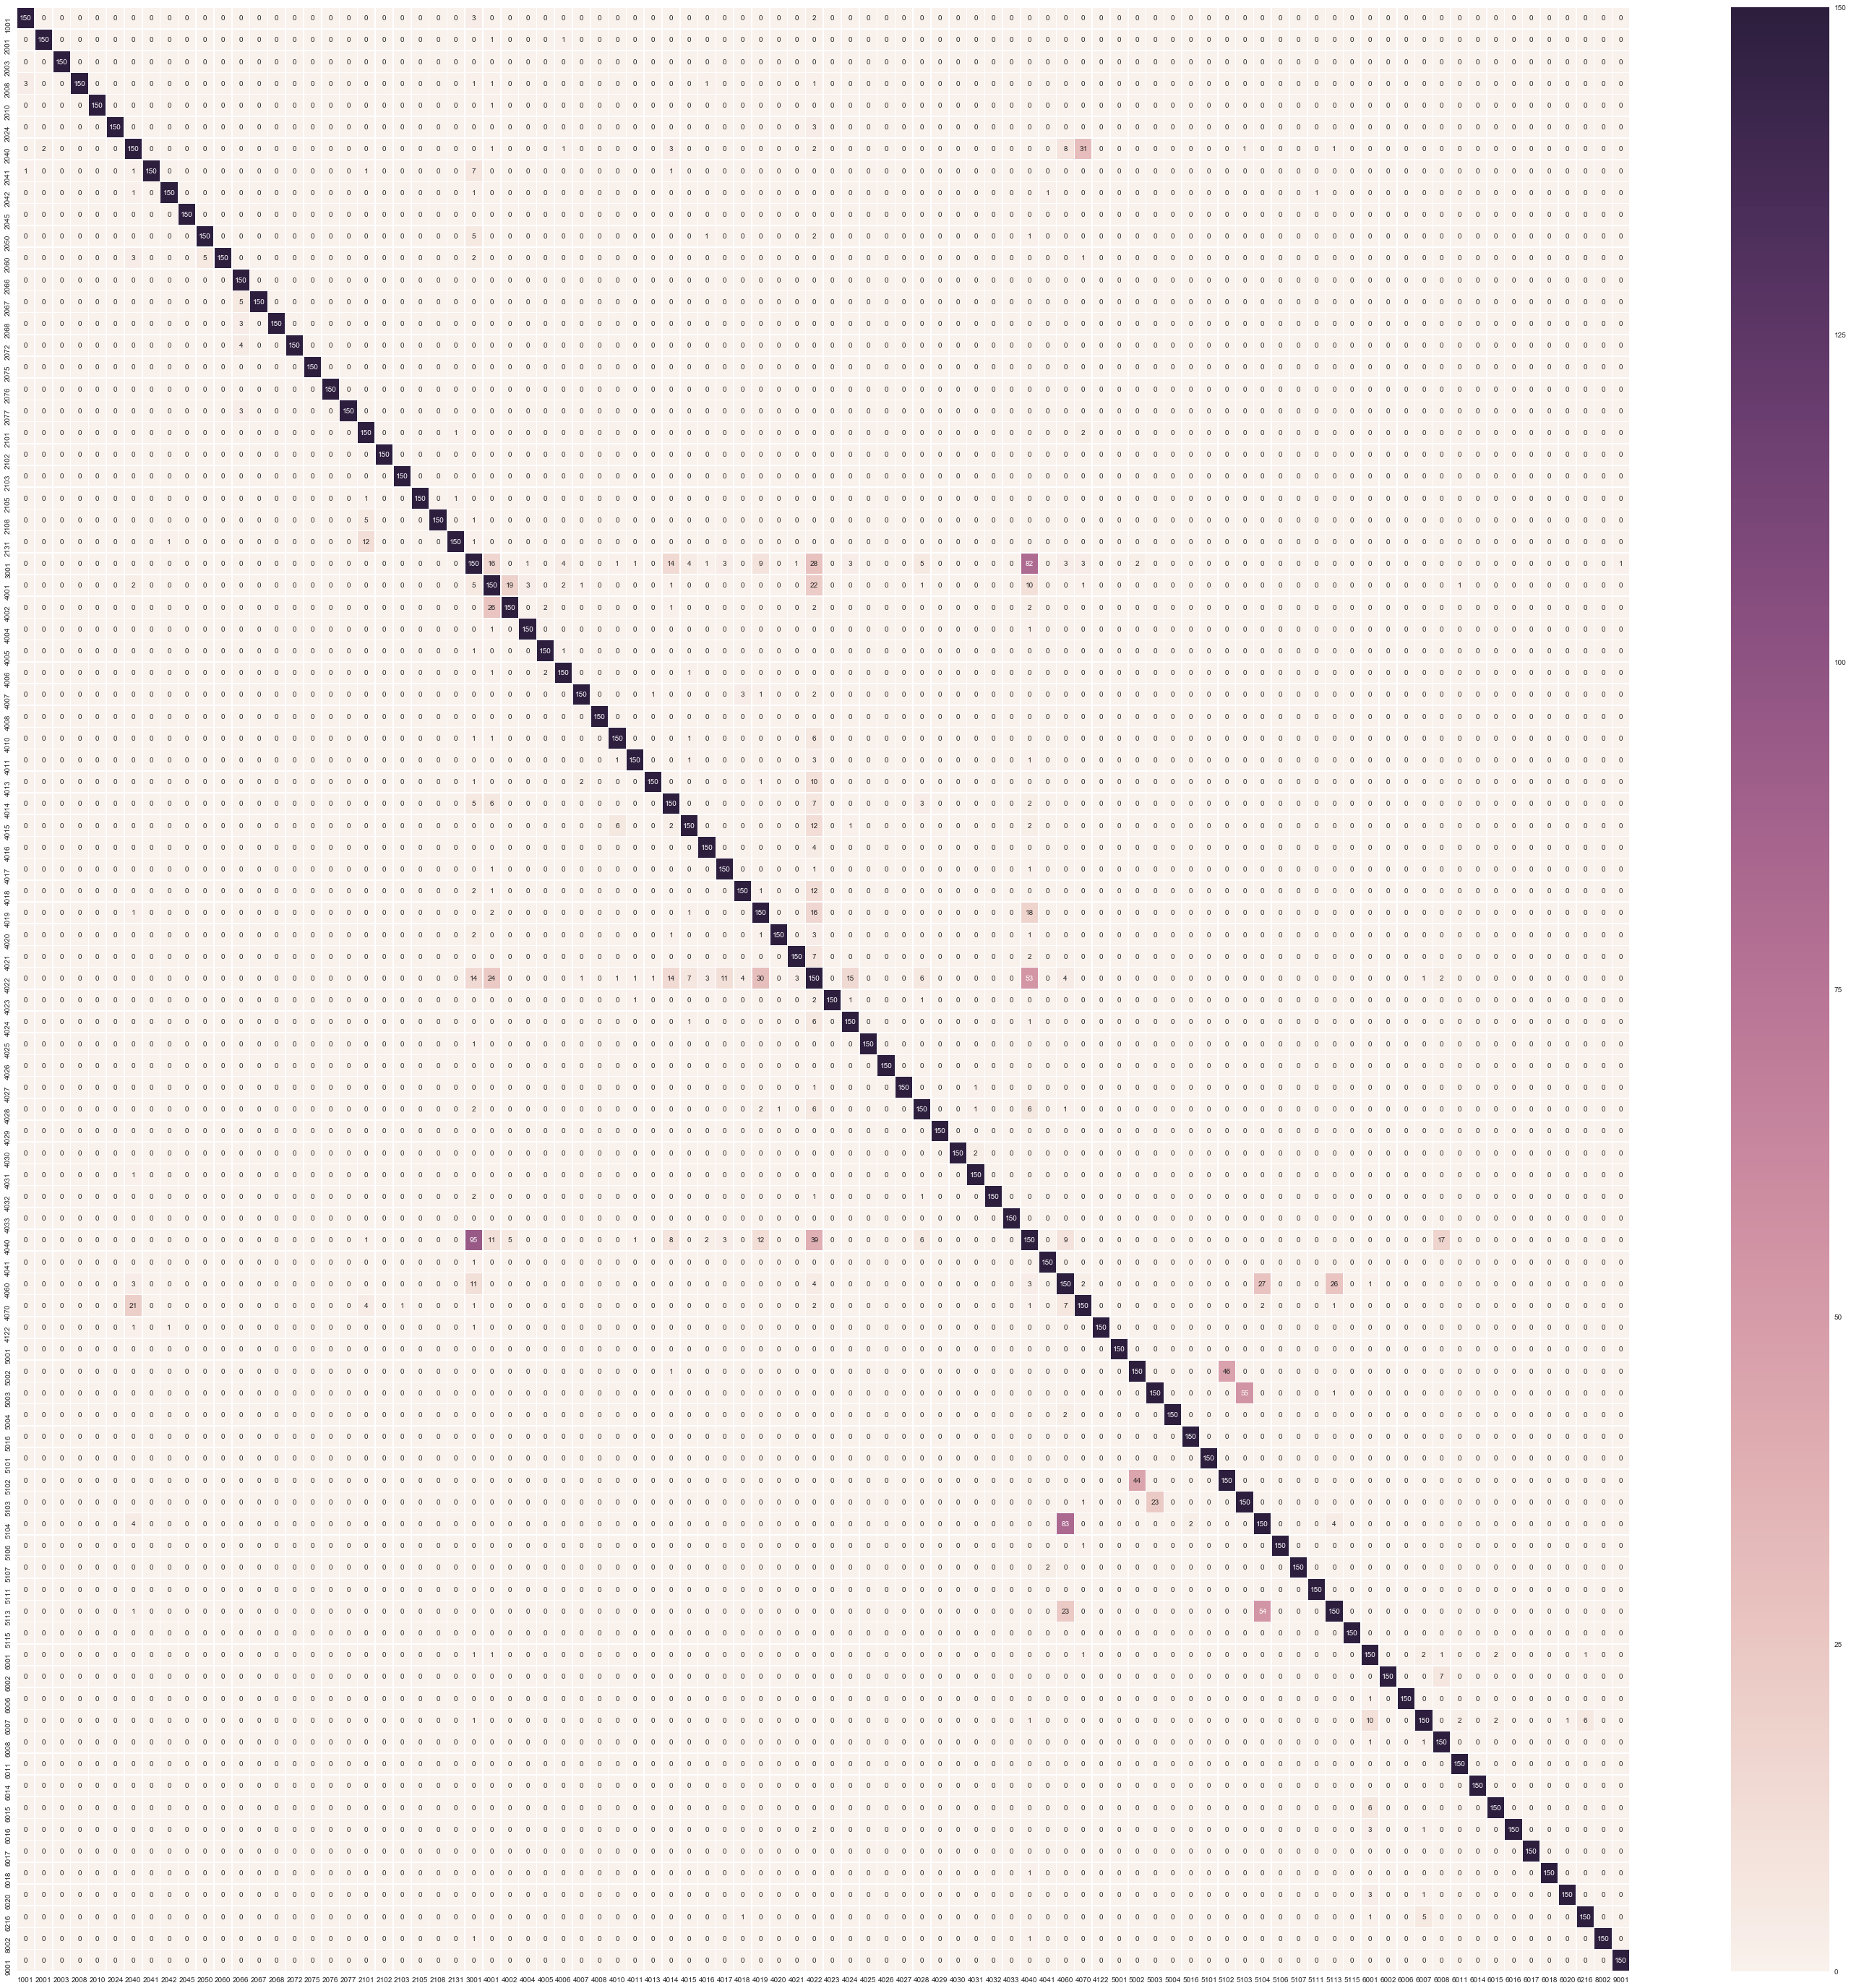

In [52]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(C_, annot=True, fmt="d", linewidths=.5, ax=ax, xticklabels=classes, yticklabels=classes)
sns.plt.savefig('heatmap_last_clf_post.png')

Take another high error from the heatmap that belongs to classification of **5113** and **4060** classes. Take a look at them:

In [71]:
X_test[(y_test == 5113) & (y_pred == 4060)][5:10]

array([ '{VO01010} Операция по продаже валюты по заявлению №0000732 от 17.10.2016. Курс 69.38250№ ref 304349<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000148 от 12.05.2016. Курс 74.18700№ ref 16979<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000179 от 15.07.2016. Курс 70.35000№ ref 23536<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       '{VO01010} Операция по продаже валюты по заявлению №0000853 от 15.11.2016. Курс 70.65000№ ref 217675<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп =',
       'Покупка/продажа валюты по заявке № 348(348).№ ref 348<<ИМЯ>НЛМК ОАО инн =4823006703'], dtype=object)

In [73]:
entry = 'Операция по продаже валюты по заявлению №0000732 от 17.10.2016. Курс 69.38250№ ref 304349<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНК инн =7730060164 кпп ='
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([5104, 5113, 2040]),
 array([  5.57869637e-01,   4.39541907e-01,   4.01541589e-04]))

In [74]:
entry = 'Покупка/продажа валюты по заявке '
find_most_probable_class(y_train, clf.predict_proba([entry]),3)

(array([4060, 5016, 4033]), array([ 0.97437371,  0.01223187,  0.00511216]))

## -1. Save data for Andrey

In [88]:
cv = best_clf.steps[0][1]
tfidf = best_clf.steps[1][1]

In [90]:
X_cv = cv.transform(X)

In [91]:
X_tfidf = tfidf.transform(X_cv)

In [140]:
df1 = pd.SparseDataFrame(X_tfidf[:,:1000])